In [1]:
import pandas as pd
import numpy as np
import os

We noticed the presence of a lot of false positives in the data. To identify them and consider only the "true positive" tweets mentioning self-reported symptoms, we asked volunteers to label our tweets through our [annotation platform](https://covid-twitter.thecommons.science/), and collected more than 7,000 annotations. We could then use these labelled tweets as a training set, and try to predict the unannotated tweets.

We use the same tweets data as in the analysis part (all tweets mentioning symptoms); we import the annotations directly from the citizen science platform.

In [2]:
path_to_data='../data'
tweets = pd.read_csv(os.path.join(path_to_data,'list_tweets_symptoms.csv'), sep=';')
annotations = pd.read_csv('https://covid-twitter.thecommons.science/download-annotations', sep=';')

In [3]:
annotations.head()

,tweet_id,symptom,uuid,timestamp
0,1283868242885345284,no,0c23bd9f-c59b-44a9-9478-9cef1e001f41,2020-08-03 16:23:06.240620+00:00
1,1276812293427388417,no,0c23bd9f-c59b-44a9-9478-9cef1e001f41,2020-08-03 16:23:13.420263+00:00
2,1239604283697516544,no,0c23bd9f-c59b-44a9-9478-9cef1e001f41,2020-08-03 16:23:27.856655+00:00
3,1249084526372048896,skip,0c23bd9f-c59b-44a9-9478-9cef1e001f41,2020-08-03 16:23:47.608572+00:00
4,1240029569513656321,no,0c23bd9f-c59b-44a9-9478-9cef1e001f41,2020-08-03 16:23:58.495652+00:00


# 1. Data preparation

In [4]:
print("Number of annotations :", len(annotations))
print("Number of tweets annotated at least once:", len(annotations['tweet_id'].unique()))

Number of annotations : 7370
Number of tweets annotated at least once: 4456


## 1.1. Clean the labels

To clean the labels, we will consider only tweets that have been labelled at least twice, and consistently (that have the same label at least 2/3 of the time).

In [5]:
# We count the number of annotations, number of tweets labelled yes, no, and skip
count_annotations=annotations.groupby(['tweet_id','symptom']).count().reset_index()
count_annotations=pd.pivot_table(count_annotations, values='uuid', index='tweet_id', columns='symptom').reset_index().fillna(0)
count_annotations['total']=count_annotations[['no','skip','yes']].sum(axis=1)
count_annotations.columns.name=None
count_annotations.head()

,tweet_id,no,skip,yes,total
0,1201454549682335745,1.0,0.0,0.0,1.0
1,1201648756476858368,0.0,1.0,1.0,2.0
2,1201650692139687936,1.0,0.0,0.0,1.0
3,1201765188959195137,0.0,1.0,1.0,2.0
4,1201776800134836224,2.0,0.0,0.0,2.0


In [6]:
# We then decide to keep only tweets that have been labelled at least twice, 
# and that have the same label at least 2/3 of the time 
count_annotations=count_annotations.loc[count_annotations['total']>=2]
def return_ids(value):
    ids=count_annotations.loc[count_annotations[value]>=count_annotations['total']*2/3, 'tweet_id'].tolist()
    return ids

for value in ['yes','no','skip']:
    print('Number of tweets labelled as ' + str(value) + ' : ' + str(len(return_ids(value))))
    
ids_yes, ids_no, ids_skip=return_ids('yes'), return_ids('no'), return_ids('skip')

Number of tweets labelled as yes : 319
Number of tweets labelled as no : 1040
Number of tweets labelled as skip : 63


## 1.2. Merge the two datasets

In [7]:
# We then use these ids to label our tweets
tweets.loc[tweets['id_str'].isin(ids_yes), 'label']=True
tweets.loc[tweets['id_str'].isin(ids_no), 'label']=False
tweets['is_annotated'] = (tweets['label'].notna())
tweets.head()

,id_str,day,anonymized_text,label,is_annotated
0,1206157336534016001,2019-12-15,Symptomatique [url],NaN,False
1,1206550539477159941,2019-12-16,#ReformeRetraite #Delevoye @mention appelle au...,NaN,False
2,1216811655738413056,2020-01-13,@mention @mention Rhume toux fièvre,True,True
3,1218113362917236737,2020-01-17,Il serait temps de condamner toutes ces feigna...,NaN,False
4,1219872603554361344,2020-01-22,@mention Parce que ça veut dire que je serais ...,NaN,False


# 2. Building a classifier

## 2.1. Reminders about Machine learning algorithms

### Global machine learning reminders

Before diving into the code, here are some definitions and reminders of machine learning algorithms.

The goal of Machine learning is to build automatic procedures to establish general rules from samples of data. We distinguish two different types of algorithms:

- **Supervised learning**. We consider $n$ i.i.d. couples $Z_i=(X_i, Y_i)$, following law $P$. $X_i \in \mathcal{X}$ (generally $\mathcal{X}=\mathbb{R}^d$) is the input variable (also called *feature*), and $Y_i \in \mathcal{Y}$ is the output variable (the label).

- **Unsupervised learning**. In unsupervised learning, we do not have the labels ($Y_i$ variable). The goal is therefore to caracterize the law of probability that generated the observations. It is often classification problems.

In supervised learning, we define the **loss function** $l(y, y')$, which measures the error in our prediction, with $y$ the real output and $y'$ the predicted output. We therefore aim to find a function $g:\mathcal{X} \rightarrow \mathcal{Y}$ that minimises the risk $R_P(g) = \mathbb{E}(l(Y, g(X))$. 

We distinguish two global problems in supervised learning, depending of the nature of $\mathcal{Y}$. If $\mathcal{Y} \in \mathbb{R}$, the problem is called **regression**; if $\mathcal{Y_i}$ is discrete, we are in the case of **classification** (more specifically, if $\mathcal{Y} \in \{0,1\}$, we talk about binary classification). In the case of classification, we therefore other consider the loss function to be $l(y, y')=\mathbb{1}(y \neq y')$, which means $l(y,y')=1$ if $y=y'$ and $l(y,y')=0$ if $y \neq y'$.

The following schema resumes the different types of algorithms.

<img src="imgs/machine-learning-classification.png" style="width: 700px;">

In our case, we are working on a classification problem: we have tweets labelled as true positive (1) or false positive (0).

## 2.2. Features building

To predict the labels (True or False positive), we use input variables $X_i$ built directly from the tweets. 

### Clean textual data

We first clean the textual data. If we did it by hand in the previous notebook, we can now use [ekphrasis](https://github.com/cbaziotis/ekphrasis), a python package specialized in the treatment of social media data. This package identifies in particular the users mentionned (@username), and the hastags.

In [8]:
from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons
from unidecode import unidecode
from nltk import ngrams

In [9]:
# Clean the textual data
# Preprocess tweets
text_processor = TextPreProcessor(
    # terms that will be normalized
    normalize=['url', 'email', 'percent', 'money', 'phone', 'user',
        'time', 'url', 'date'],
    # terms that will be annotated
    annotate={"hashtag",  "repeated",
        'emphasis', 'censored'},
    fix_html=True,  # fix HTML tokens
    
    # corpus from which the word statistics are going to be used 
    # for word segmentation 
    segmenter="twitter", 
    
    # corpus from which the word statistics are going to be used 
    # for spell correction
    corrector="twitter", 
    
    unpack_hashtags=True,  # perform word segmentation on hashtags
    unpack_contractions=True,  # Unpack contractions (can't -> can not)
    spell_correct_elong=False,  # spell correction for elongated words
    
    # select a tokenizer. You can use SocialTokenizer, or pass your own
    # the tokenizer, should take as input a string and return a list of tokens
    
    #tokenizer=SocialTokenizer(lowercase=True).tokenize,
    
    dicts=[emoticons]
)

tweets['clean_text'] = tweets['anonymized_text'].apply(lambda x:text_processor.pre_process_doc(x).lower()) 
tweets.head()

Reading twitter - 1grams ...
Reading twitter - 2grams ...


/home/ubuntu/.local/lib/python3.7/site-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
  regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


Reading twitter - 1grams ...


,id_str,day,anonymized_text,label,is_annotated,clean_text
0,1206157336534016001,2019-12-15,Symptomatique [url],NaN,False,symptomatique [url]
1,1206550539477159941,2019-12-16,#ReformeRetraite #Delevoye @mention appelle au...,NaN,False,<hashtag> reforme retraite </hashtag> <hashtag...
2,1216811655738413056,2020-01-13,@mention @mention Rhume toux fièvre,True,True,<user> <user> rhume toux fièvre
3,1218113362917236737,2020-01-17,Il serait temps de condamner toutes ces feigna...,NaN,False,il serait temps de condamner toutes ces feigna...
4,1219872603554361344,2020-01-22,@mention Parce que ça veut dire que je serais ...,NaN,False,<user> parce que ça veut dire que je serais en...


In [10]:
def clean_text(text):
    
    # ekphrasis package adds two hashtags (before and after the word), we want to keep only one
    text=text.replace('</hashtag>','').replace('[url]','<url>')
    
    # remove accents
    text=unidecode(text)
    
    # remove punctuation
    text=text.replace('^\sa-zA-Z0-9@',' ')

    return text
tweets['clean_text'] = tweets['clean_text'].apply(lambda x: clean_text(x))

### Tokenizing and ngrams

To use the tweets as features, we need to create several variables based on textual data. We will first **tokenize** the data, which means we distinguish the different words (called *tokens*) in the texts. 
We also build **n-grams**, which are groups of tokens, so that we can consider associations of words ; for example, we will consider not only *"tousse"*, but *"je tousse"* (bigram) or *"je tousse beaucoup"* (trigram).

We use the tokenizer from ekphrasis and the ngrams function from [nltk](http://www.nltk.org/api/nltk.html).

In [11]:
tokenizer=SocialTokenizer(lowercase=True).tokenize
tweets['tokens']=tweets['clean_text'].apply(lambda x: tokenizer(x))
tweets['bigrams']=tweets['tokens'].apply(lambda x: list(ngrams(x,2)))
tweets['trigrams']=tweets['tokens'].apply(lambda x: list(ngrams(x,3)))

tweets['bigrams']=tweets['bigrams'].apply(lambda x: [' '.join(token) for token in x])
tweets['trigrams']=tweets['trigrams'].apply(lambda x: [' '.join(token) for token in x])

tweets['tokens']=tweets['tokens']+tweets['bigrams']+tweets['trigrams']

/home/ubuntu/.local/lib/python3.7/site-packages/ekphrasis/classes/tokenizer.py:225: FutureWarning: Possible nested set at position 2190
  self.tok = re.compile(r"({})".format("|".join(pipeline)))


In [12]:
tweets.head()

,id_str,day,anonymized_text,label,is_annotated,clean_text,tokens,bigrams,trigrams
0,1206157336534016001,2019-12-15,Symptomatique [url],NaN,False,symptomatique <url>,"[symptomatique, <url>, symptomatique <url>]",[symptomatique <url>],[]
1,1206550539477159941,2019-12-16,#ReformeRetraite #Delevoye @mention appelle au...,NaN,False,<hashtag> reforme retraite <hashtag> delevoye...,"[<hashtag>, reforme, retraite, <hashtag>, dele...","[<hashtag> reforme, reforme retraite, retraite...","[<hashtag> reforme retraite, reforme retraite ..."
2,1216811655738413056,2020-01-13,@mention @mention Rhume toux fièvre,True,True,<user> <user> rhume toux fievre,"[<user>, <user>, rhume, toux, fievre, <user> <...","[<user> <user>, <user> rhume, rhume toux, toux...","[<user> <user> rhume, <user> rhume toux, rhume..."
3,1218113362917236737,2020-01-17,Il serait temps de condamner toutes ces feigna...,NaN,False,il serait temps de condamner toutes ces feigna...,"[il, serait, temps, de, condamner, toutes, ces...","[il serait, serait temps, temps de, de condamn...","[il serait temps, serait temps de, temps de co..."
4,1219872603554361344,2020-01-22,@mention Parce que ça veut dire que je serais ...,NaN,False,<user> parce que ca veut dire que je serais en...,"[<user>, parce, que, ca, veut, dire, que, je, ...","[<user> parce, parce que, que ca, ca veut, veu...","[<user> parce que, parce que ca, que ca veut, ..."


### Vectorizing the data

We build features as vectors, which means we want tokens to be converted into numbers.

There are several options of vectorizing textual data:
- [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html): Convert a collection of text documents to a matrix of token counts.
- [TdidfVectorize](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html): TF-IDF features. The particularity of TF-IDF is that it evaluates the relative importance of a word in a document: the weight depends of the occurence of the word in the document, and of the occurence of this word in the whole corpus.

In these functions, we consider ngrams until 4. It is possible to include stopwords as well but we do not: tweets are very small texts and stopwords ('je', 'mais',...) can be very important to detect true positives in our case.

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import train_test_split # Import train_test_split function


# Create features, using 4-gram
def vectorize_data(vectorizer, num_features):

    vect = vectorizer(max_features = num_features, strip_accents='unicode',
                            lowercase=True, ngram_range=(1,4))
    print('Fitting Data...')
    vect.fit(tweets['clean_text'].values.astype('U'))

    print('Starting Transform...')
    text = vect.transform(tweets['clean_text'])

    print('Label and Incorporate TF-IDF...')
    data_array = pd.DataFrame(text.toarray())
    feature_names = vect.get_feature_names()

    for i in range(num_features):
        feature_names[i] = 'token_' + feature_names[i]

    data_array.columns = feature_names
    tweets_vectorized = pd.concat([tweets, data_array], axis=1)

    return tweets_vectorized

In [14]:
# We will take CountVectorizer, with 1,000 features
tweets_classif = vectorize_data(CountVectorizer, 1000)
tweets_classif.head(2)

Fitting Data...
Starting Transform...
Label and Incorporate TF-IDF...


,id_str,day,anonymized_text,label,is_annotated,clean_text,tokens,bigrams,trigrams,token_10,...,token_vos,token_votre,token_vous,token_vous avez,token_vous etes,token_vrai,token_vraiment,token_vu,token_wsh,token_yeux
0,1206157336534016001,2019-12-15,Symptomatique [url],NaN,False,symptomatique <url>,"[symptomatique, <url>, symptomatique <url>]",[symptomatique <url>],[],0,...,0,0,0,0,0,0,0,0,0,0
1,1206550539477159941,2019-12-16,#ReformeRetraite #Delevoye @mention appelle au...,NaN,False,<hashtag> reforme retraite <hashtag> delevoye...,"[<hashtag>, reforme, retraite, <hashtag>, dele...","[<hashtag> reforme, reforme retraite, retraite...","[<hashtag> reforme retraite, reforme retraite ...",0,...,0,0,0,0,0,0,0,0,0,0


## 2.3. Training a classifier

### Split of training - testing set

Supervised machine learning algorithms are usually trained on a subset of the whole dataset: we split the data in a training set ($(X_{train}, Y_{train})$, 70% of the data), on which we train the model, and testing ($(X_{test}, Y_{test})$, 30% of the data), on which we evaluate the model. That way, we evaluate the model on a set of data on which the model has not been fit.

<img src="imgs/train-test.png" style="width: 400px;">

We consider as $X$ the features, obtained with CountVectorizer or TfidfVectorizer ; and $Y$ the labels. We only consider the tweets that were annotated.
We use the [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function from scikit learn.
The parameter "random state" is there to make sure that the split will be the same.

In [15]:
X = tweets_classif.loc[tweets_classif['is_annotated']==True,tweets_classif.columns.str.startswith('token_')]
Y = tweets_classif.loc[tweets_classif['is_annotated']==True,'label'].astype('str')
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

### Training a Logistic Regression model

We use a [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) model, which is often used in problems of binary classification, and is a particular case of linear regression, in which the output is a class and not a value.

The Logistic regression is based on the sigmoïd function $\sigma (x) = \frac{1}{1+e^{-x}}$, which has the particularity of transforming every value it takes into a number between 0 and 1. It then estimates the probability of belonging to a class or to the other one, with a threshold at 0.5.

<img src="imgs/sigmoid.png" style="width: 500px;">

In [16]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
clf.fit(X_train, y_train)

LogisticRegression()

## 2.4. Evaluating the classifier

### Different metrics

We can use several metrics to measure and assess the performance of a classifier. In the case of classification, we usually use *accuracy*, *precision*, *recall*, and *f1-score*. These metrics let us evaluate how our model is mistaken to predict the labels. 

- **accuracy**: proportion of well-classified elements. $accuracy= \frac {TP + TN}{n}$
- **precision**: measures the pertinence of the information. $precision = \frac{TP}{TP + FP}$ If *precision* is high, we make sure most of the elements of class $k$ are supposed to be in that class, even if a lot of elements that are supposed to be in class $k$ get misclassified.
- **recall**: measures the quantity of the information. $recall = \frac{TP}{TP+FN}$ If *recall* is high, we make sure most of the elements of the class $k$ are well predicted, even if class $k$ might contains a lot of misclassified elements.
- **f1-score** is a weighted average of precision and recall. $F1 = 2 \frac{precision * recall}{precision + recall}$

where $TP$ is *true positives*, which is the number of tweets that have been classified in the true category; $FP$, *false negatives*, the number of tweets that have been classied in class $k$ while they are not supposed to; $FN$, *false negatives*, the number of tweets that have been classified in another class than the class $k$ in which they were supposed to. The metrics *precision*, *recall*, and *f1-score* are computed for each class.

While the *accuracy* gives us a global idea of the performance of the algorithm, it is important to compute the others metrics in case of unbalanced data (if a class contains most of the data).

In [17]:
from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix, plot_roc_curve
from sklearn import metrics
import matplotlib.pyplot as plt

import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [18]:
def plot_confusion_matrix(dataset, model):
    
    if dataset=='training':
        y_data, X_data = y_train, X_train
    elif dataset=='test':
        y_data, X_data = y_test, X_test

    cm = confusion_matrix(y_data,model.predict(X_data))
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(cm)
    ax.grid(False)
    ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted False', 'Predicted True'))
    ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual False', 'Actual True'))
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(20) 
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(20) 
    ax.set_ylim(1.5, -0.5)
    for i in range(2):
        for j in range(2):
            ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
    plt.show()

In [19]:
def plot_precision_recall(dataset, model):
    
    if dataset=='training':
        y_data, X_data = y_train, X_train
    elif dataset=='test':
        y_data, X_data = y_test, X_test
        
    y_probs=model.predict_proba(X_data) 

    precision, recall, thresholds = precision_recall_curve(y_data.replace({'True': 1, 'False': 0}), y_probs[:, 1]) 
       #retrieve probability of being 1(in second column of probs_y)
    pr_auc = metrics.auc(recall, precision)

    plt.title("Precision-Recall vs Threshold Chart")
    plt.plot(thresholds, precision[: -1], "b--", label="Precision")
    plt.plot(thresholds, recall[: -1], "r--", label="Recall")
    plt.ylabel("Precision, Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="lower left")
    plt.ylim([0,1])
    plt.show()

    metrics.plot_precision_recall_curve(model,X_data, y_data)
    plt.show()

### Results on the training set

In [20]:
print(classification_report(y_train, clf.predict(X_train)) )

              precision    recall  f1-score   support

       False       0.98      0.99      0.99       732
        True       0.97      0.93      0.95       219

    accuracy                           0.98       951
   macro avg       0.97      0.96      0.97       951
weighted avg       0.98      0.98      0.98       951



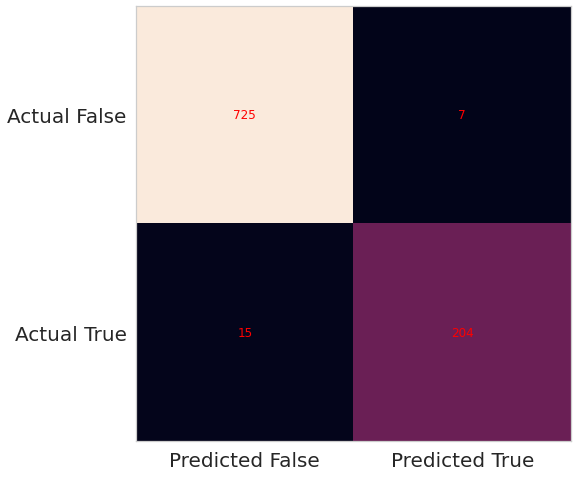

In [21]:
plot_confusion_matrix('training', clf)

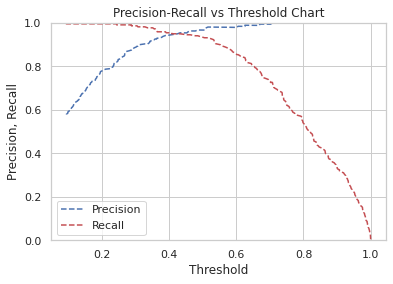

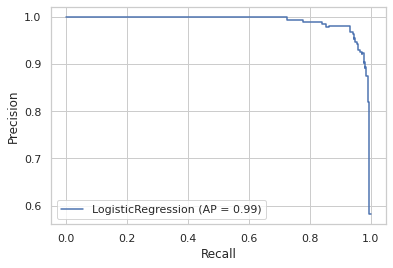

In [22]:
plot_precision_recall('training', clf)

### Results on the test set

In [23]:
print(classification_report(y_test, clf.predict(X_test)) )

              precision    recall  f1-score   support

       False       0.87      0.94      0.90       308
        True       0.74      0.57      0.64       100

    accuracy                           0.85       408
   macro avg       0.81      0.75      0.77       408
weighted avg       0.84      0.85      0.84       408



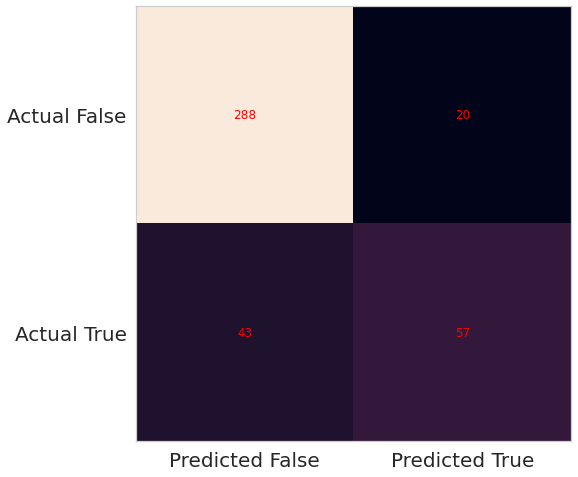

In [24]:
plot_confusion_matrix('test', clf)

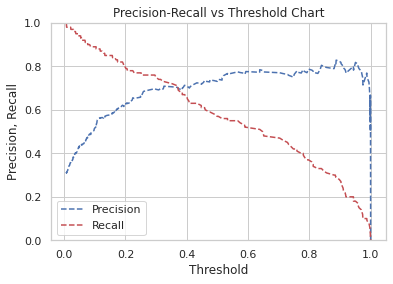

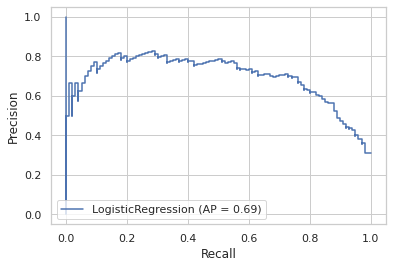

In [25]:
plot_precision_recall('test', clf)

We notice that if our algorithm is quite performant on the training set, it becomes less performant on the test set, and especially in the prediction of the *yes* class. The high "accuracy" score is mainly due to the fact that our classes are unbalanced.
Besides, this phenomena in which the model is better on the training than on the test set is called **overfitting**: it happens when our model is too dependant on the data, and cannot adapt to a new set of data. To overcome this issue, we can cross-validate our model.

# TO BE CONTINUED

## 2.5. Hyperparameters tuning and cross validation

### Hyperparameters tuning

explanation of the hyperparameters : they can improve the quality of our model. Give some examples.

### Cross validation

To avoid overfitting, cross validate.


<img src="imgs/cross-validation.PNG" style="width: 500px;">

### GridSearch

Can be done with function gridsearch

In [26]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [27]:
# Create first pipeline for base without reducing features.
pipe = Pipeline([('classifier' , LogisticRegression())])

# Create param grid.
param_grid = [
    {'classifier' : [LogisticRegression()],
     'classifier__penalty' : ['l1','l2'],
    'classifier__C' : np.logspace(-4, 4, 20),
    'classifier__solver' : ['liblinear'],
    'classifier__class_weight':['balanced']}
]

# Create grid search object
clf = GridSearchCV(pipe, param_grid = param_grid, cv = 3, verbose=True, n_jobs=-1)
#clf=LogisticRegression(solver='liblinear',penalty='l2')
#clf=LogisticRegressionCV(solver='liblinear',scoring='recall',penalty='l2')
# Fit on data

best_clf = clf.fit(X_train, y_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    2.1s finished


In [28]:
best_clf.get_params()

{'cv': 3,
 'error_score': nan,
 'estimator__memory': None,
 'estimator__steps': [('classifier', LogisticRegression())],
 'estimator__verbose': False,
 'estimator__classifier': LogisticRegression(),
 'estimator__classifier__C': 1.0,
 'estimator__classifier__class_weight': None,
 'estimator__classifier__dual': False,
 'estimator__classifier__fit_intercept': True,
 'estimator__classifier__intercept_scaling': 1,
 'estimator__classifier__l1_ratio': None,
 'estimator__classifier__max_iter': 100,
 'estimator__classifier__multi_class': 'auto',
 'estimator__classifier__n_jobs': None,
 'estimator__classifier__penalty': 'l2',
 'estimator__classifier__random_state': None,
 'estimator__classifier__solver': 'lbfgs',
 'estimator__classifier__tol': 0.0001,
 'estimator__classifier__verbose': 0,
 'estimator__classifier__warm_start': False,
 'estimator': Pipeline(steps=[('classifier', LogisticRegression())]),
 'iid': 'deprecated',
 'n_jobs': -1,
 'param_grid': [{'classifier': [LogisticRegression(C=0.6158

In [29]:
best_clf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.7s finished


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('classifier', LogisticRegression())]),
             n_jobs=-1,
             param_grid=[{'classifier': [LogisticRegression(C=0.615848211066026,
                                                            class_weight='balanced',
                                                            solver='liblinear')],
                          'classifier__C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                          'classifier__class_weight': ['balanced'],
                          'classifier__penalty': ['l1', 'l2'],
                          'classifier__solver': ['liblinear']}],
             verbose=True)

### Results on training set

In [30]:
print(classification_report(y_train, best_clf.predict(X_train)) )

              precision    recall  f1-score   support

       False       1.00      0.95      0.97       732
        True       0.85      0.99      0.91       219

    accuracy                           0.96       951
   macro avg       0.92      0.97      0.94       951
weighted avg       0.96      0.96      0.96       951



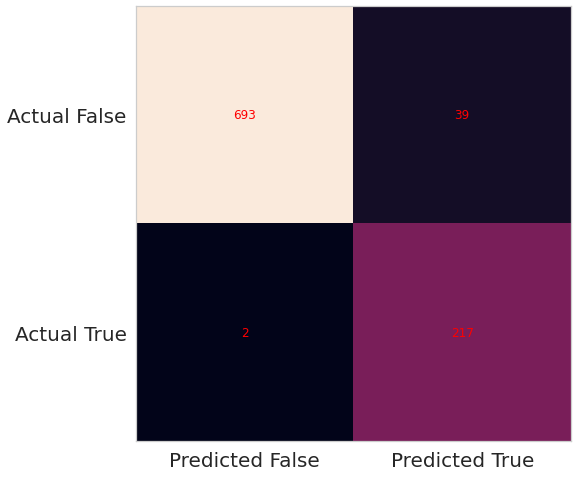

In [31]:
plot_confusion_matrix('training', best_clf)

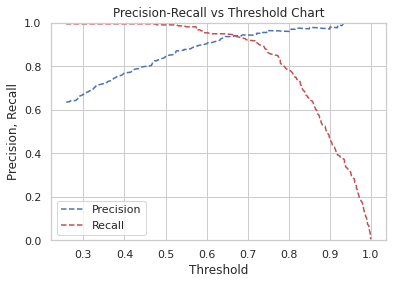

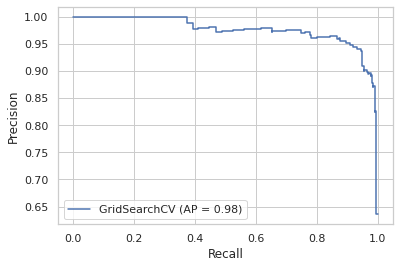

In [32]:
plot_precision_recall('training', best_clf)

### Results on testing set

In [33]:
print(classification_report(y_test, best_clf.predict(X_test)) )

              precision    recall  f1-score   support

       False       0.91      0.90      0.91       308
        True       0.70      0.74      0.72       100

    accuracy                           0.86       408
   macro avg       0.81      0.82      0.81       408
weighted avg       0.86      0.86      0.86       408



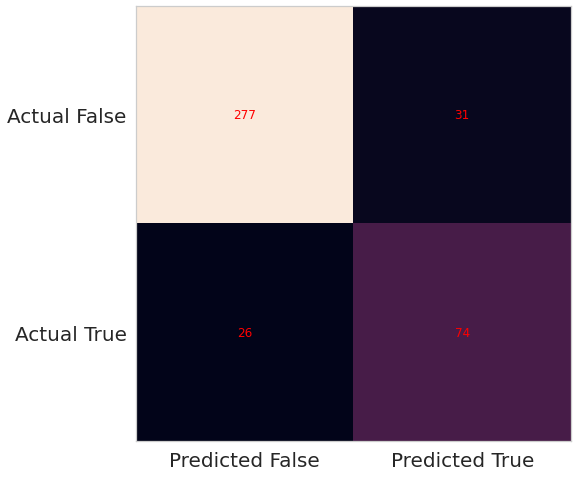

In [34]:
plot_confusion_matrix('test', best_clf)

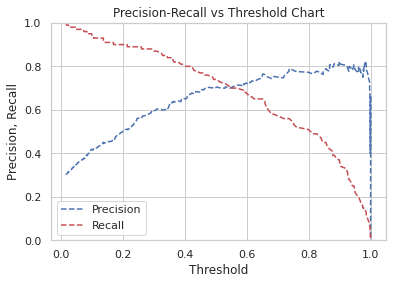

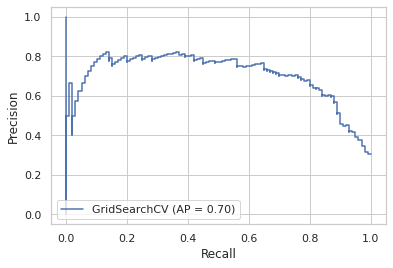

In [35]:
plot_precision_recall('test', best_clf)

# 3. Plot the results

After having this classifier, we can extend our analysis and predict, on the whole sample of tweets (included those that were not annotated), which ones are true positives.

### Predicting the labels of all tweets with the classifier best_clf

In [36]:
X_new = tweets_classif.loc[:, tweets_classif.columns.str.startswith('token_')]
tweets_classif['new_label'] = best_clf.predict(X_new)

In [37]:
# Crosstab on the tweets that were annotated
pd.crosstab(tweets_classif.loc[tweets_classif['is_annotated']==True,'new_label'],
            tweets_classif.loc[tweets_classif['is_annotated']==True,'label'])

label,False,True
new_label,,
False,970,28
True,70,291


### Plot the results

In [38]:
tweets_classif['n_symptom']=1
tweets_classif.loc[tweets_classif['new_label']=='True', 'n_true_positive']=1
tweets_day=tweets_classif.groupby('day').agg('sum').reset_index()[['day','n_symptom','n_true_positive']]

In [39]:
import plotly.figure_factory as ff
import plotly.offline as py
import plotly.graph_objs as go
from plotly import tools
py.init_notebook_mode(connected = True)

In [40]:
def plot_true_positives() :
    traces=[]


    traces.append(go.Scatter(x = tweets_day['day'], 
                            y = tweets_day['n_true_positive'].rolling(7).mean(),
                            mode = 'lines',
                             name = 'Symptoms_predicted',
                            line=dict(color='yellow'),
                             yaxis='y1'))
    
    traces.append(go.Scatter(x = tweets_day['day'], 
                            y = tweets_day['n_symptom'].rolling(7).mean(),
                            mode = 'lines',
                             name = 'Number of tweets mentionning symptoms',
                            line=dict(color='red'),
                             yaxis='y2'))
    
    layout = go.Layout(title="Comparison between the number of tweets mentioning symptoms and the number of tweets predicted as true positives",
                       yaxis=dict(title='Number of tweets predicted as true positives'),
                       yaxis2=dict(title='Number of tweets mentioning symptoms',
                                   overlaying='y',
                                   side='right'))
    fig = go.Figure(traces, layout)
    
    fig.add_shape(dict(type="rect",
                       yref='paper',
                       x0='2020-03-17',
                       y0=0,
                       x1='2020-05-11',
                       y1=1,
                       fillcolor="LightSalmon",
                       opacity=0.2,
                       layer='below',
                       line_width=0))
    
    fig.update_layout(annotations=[dict(
        x='2020-04-15',
        y=0.9,
        yref="paper",
        text="Lockdown (France)", showarrow=False)])
    
    py.iplot(fig)
plot_true_positives()

# 4. Your turn!

If you want to practice on waht we just saw, you can:
- Try another method of vectorization of the tokens (TfidfVectorize for example)
- Try other algorithms (RandomForest for example)
- Plot the number of tweets predicted as true positives against the emergencies data and compute the correlation